In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline

In [246]:
import re
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [96]:
from sklearn import cross_validation
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Loading the Data

In [97]:
Loan_Details = pd.read_csv('Loan.csv')

/Users/poojachoudhary/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [98]:
Loan_Details.shape

(887379, 74)

In [99]:
Loan_Details.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m
0,1077501,1296599,5000.0,5000.0,4975.0,36 months,10.65,162.87,B,B2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1077430,1314167,2500.0,2500.0,2500.0,60 months,15.27,59.83,C,C4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1077175,1313524,2400.0,2400.0,2400.0,36 months,15.96,84.33,C,C5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1076863,1277178,10000.0,10000.0,10000.0,36 months,13.49,339.31,C,C1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1075358,1311748,3000.0,3000.0,3000.0,60 months,12.69,67.79,B,B5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Dropping Features having more than 80% Missing Values

In [100]:
pct_null = Loan_Details.isnull().sum() / len(Loan_Details)
missing_features = pct_null[pct_null > 0.8].index
len(missing_features)

19

In [101]:
Loan_Details_Clean = Loan_Details.drop(missing_features,axis = 1)

In [102]:
Loan_Details_Clean.shape

(887379, 55)

# Imputing the Missing Values for the Remaining Features

In [103]:
pct_null = Loan_Details_Clean.isnull().sum() / len(Loan_Details_Clean)
missing_features = pct_null[pct_null > 0].index
len(missing_features)

20

In [104]:
Loan_Details_Clean[missing_features].dtypes

emp_title                       object
annual_inc                     float64
title                           object
delinq_2yrs                    float64
earliest_cr_line                object
inq_last_6mths                 float64
mths_since_last_delinq         float64
open_acc                       float64
pub_rec                        float64
revol_util                     float64
total_acc                      float64
last_pymnt_d                    object
next_pymnt_d                    object
last_credit_pull_d              object
collections_12_mths_ex_med     float64
mths_since_last_major_derog    float64
acc_now_delinq                 float64
tot_coll_amt                   float64
tot_cur_bal                    float64
total_rev_hi_lim               float64
dtype: object

In [105]:
for mf in missing_features:
    if Loan_Details_Clean[mf].dtypes == 'object':
        Loan_Details_Clean[mf].fillna(Loan_Details_Clean[mf].value_counts().index[0],inplace = True)
    else:
        Loan_Details_Clean[mf].fillna(Loan_Details_Clean[mf].median(),inplace = True)

# Final Check for Missing Values 

In [106]:
pct_null = Loan_Details_Clean.isnull().sum() / len(Loan_Details_Clean)
missing_features = pct_null[pct_null > 0].index
len(missing_features)

0

# Data Preprocessing

In [107]:
Loan_Details_Clean.drop(['id','member_id','url'], axis =1,inplace = True)

In [108]:
Loan_Details_Clean['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

In [109]:
Loan_Details_Clean['loan_status'].replace(('Does not meet the credit policy. Status:Fully Paid',
                            'Does not meet the credit policy. Status:Charged Off'),('Fully Paid','Charged Off'),inplace = True)

In [110]:
Loan_Details_Clean['loan_status'].replace(('Charged Off'),('Default'),inplace = True)

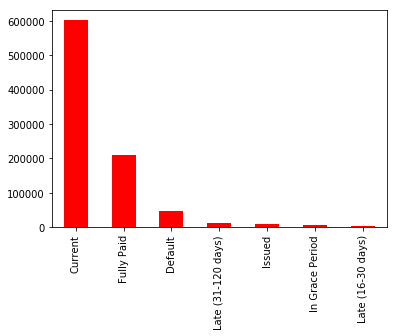

In [111]:
(Loan_Details_Clean['loan_status'].value_counts()).plot(kind='bar', color="red")

I removed the term 'Doesn't meet credit policy' as those loans were issued before the change in credit policy but the loan are exactly the same.
Next, I removed all the late loans, current loans and loans that are just being issued, as these fall into a certain grey area with ambiguous, undetermined final statuses. 
I next combined the “Default” loans with the “Charged Off” loans into one category of 'Default', leaving me with two final labels for my classification attempts - 'Fully Paid' or 'Default'.

In [187]:
Loan_details_final = Loan_Details_Clean[Loan_Details_Clean['loan_status'].isin (['Fully Paid','Default'])]

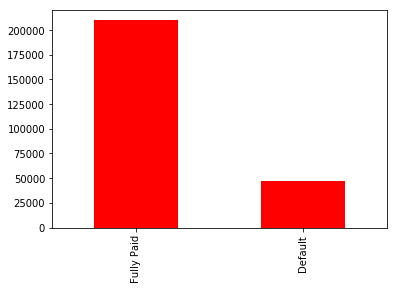

In [188]:
(Loan_details_final['loan_status'].value_counts()).plot(kind='bar', color="red")

In [189]:
Loan_details_final['verification_status'].value_counts()

Verified           94002
Not Verified       88174
Source Verified    74763
Name: verification_status, dtype: int64

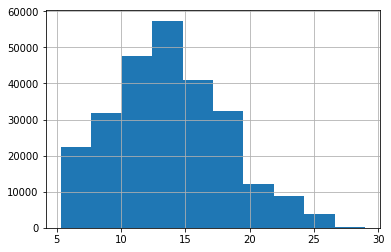

In [190]:
Loan_details_final['int_rate'].hist()

In [191]:
Loan_details_final['term'].value_counts()

 36 months    199811
 60 months     57128
Name: term, dtype: int64

In [192]:
Loan_details_final.shape

(256939, 52)

In [226]:
Loan_details_final.dtypes

loan_amnt                      float64
funded_amnt                    float64
funded_amnt_inv                float64
term                            object
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_title                       object
emp_length                      object
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_d                         object
loan_status                     object
pymnt_plan                      object
purpose                         object
title                           object
zip_code                        object
addr_state                      object
dti                            float64
delinq_2yrs                    float64
earliest_cr_line                object
inq_last_6mths                 float64
mths_since_last_delinq         float64
open_acc                 

# Removing the features from the dataset which will not be available before the loan is issued like the acc_now_delinq which indicates whether the loan payment has been missed or the grade and sub-grade which is provided by lending co.

In [197]:
Loan = Loan_details_final[['loan_amnt','funded_amnt','funded_amnt_inv','term','int_rate','installment','emp_length',
                          'emp_title','home_ownership','annual_inc','verification_status','loan_status','pymnt_plan',
                         'purpose','title','zip_code','addr_state','dti','application_type']]

# Label Encoding the Categorical Features

In [199]:
categorical = Loan.select_dtypes(include=[object]).columns

In [200]:
categorical

Index(['term', 'emp_length', 'emp_title', 'home_ownership',
       'verification_status', 'loan_status', 'pymnt_plan', 'purpose', 'title',
       'zip_code', 'addr_state', 'application_type'],
      dtype='object')

In [201]:
loan_c = Loan[categorical].apply(LabelEncoder().fit_transform)

In [204]:
loan_c.shape

(256939, 12)

In [205]:
Loan.drop(categorical,axis = 1, inplace = True)

/Users/poojachoudhary/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [206]:
Loan_final = pd.concat([loan_c,Loan],axis = 1)

# Spliting data into test- train

In [208]:
X_train = Loan_final.drop('loan_status',axis = 1)
Y_train = Loan_final['loan_status']

In [209]:
x_train,x_test,y_train,y_test = cross_validation.train_test_split(X_train,Y_train,test_size = 0.3,random_state = 0,stratify=Y_train)

In [210]:
y_test.value_counts()

1    62914
0    14168
Name: loan_status, dtype: int64

# Fitting the Model

In [230]:
classifier_LR = LogisticRegression(penalty='l2',random_state = 0) #Logistic Regression
classifier_RF = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0) #Random Forest
classifier_KNN = KNeighborsClassifier(n_neighbors = 7, metric = 'minkowski', p = 4) #K-Nearest Neighbor

# Logistic Regression

In [212]:
classifier_LR.fit(x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=0, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [214]:
predict_LR = classifier_LR.predict_proba(x_test)

In [215]:
y_pred_LR = predict_LR[:,1]

In [216]:
auc_score_LR = roc_auc_score(y_test,y_pred_LR)
auc_score_LR

0.59702411183150583

# Random Forest

In [217]:
classifier_RF.fit(x_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [219]:
predict_RF = classifier_RF.predict_proba(x_test) #Prediction in Test Set

In [220]:
y_pred_RF = predict_RF[:,1]
auc_score_RF = roc_auc_score(y_test,y_pred_RF)
auc_score_RF

0.69248233523837133

# K-Nearest Neighbour

In [231]:
classifier_KNN.fit(x_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=7, p=4,
           weights='uniform')

In [222]:
predict_KNN = classifier_KNN.predict(x_test)

In [232]:
predict_KNN = classifier_KNN.predict_proba(x_test) #Prediction in Test Set
y_pred_KNN = predict_KNN[:,1]
auc_score_KNN = roc_auc_score(y_test,y_pred_KNN)
auc_score_KNN

0.55695423991435555

# AUC_ROC Curve

In [269]:
fpr_KNN, tpr_KNN, _ = roc_curve(y_test, y_pred_KNN)
roc_auc_KNN = auc(fpr_KNN, tpr_KNN)

In [267]:
fpr_LR, tpr_LR, _ = roc_curve(y_test, y_pred_LR)
roc_auc_LR = auc(fpr_LR, tpr_LR)

In [266]:
fpr_RF, tpr_RF, _ = roc_curve(y_test, y_pred_RF)
roc_auc_RF = auc(fpr_RF, tpr_RF)

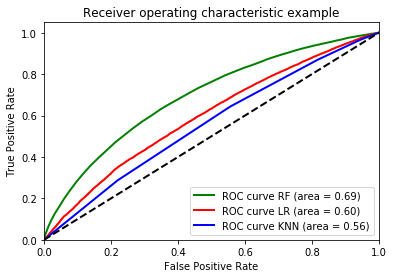

In [273]:
plt.figure()
plt.plot(fpr_RF, tpr_RF, color='green',
         lw=2, label='ROC curve RF (area = %0.2f)' % roc_auc_RF)
plt.plot(fpr_LR, tpr_LR, color='red',
         lw=2, label='ROC curve LR (area = %0.2f)' % roc_auc_LR)
plt.plot(fpr_KNN, tpr_KNN, color='blue',
         lw=2, label='ROC curve KNN (area = %0.2f)' % roc_auc_KNN)
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")